# 04 — Infer Videos → PGN (Submission)

Use board warp + per‑cell CNN + rule engine to output PGN per video.

- Reads videos from `data/public/videos/*.mp4` (local) or a Kaggle input path you specify.
- Loads model from `models/cell_cnn.h5`.
- Writes `submissions/submission.csv` with `row_id,output`.


In [1]:
# =========================
# 04 – Inference Runner (using chess_tracker.inference)
# =========================
import os, sys, csv, json
from pathlib import Path
import numpy as np
# from tqdm import tqdm  # ใช้ค่อยเปิด ถ้าไม่ใช้ให้คอมเมนต์ไว้เพื่อตัด warning

# --- env: local vs Kaggle ---
ON_KAGGLE = Path("/kaggle").exists()
ROOT = Path("/kaggle/working") if ON_KAGGLE else Path("..").resolve()

# ให้ import โค้ดใน src ได้
sys.path.insert(0, str(ROOT / "src"))
sys.path.insert(0, str(ROOT))

# --- project modules ---
from Chess_Detection_Competition.utils import load_config

# 1) ใช้ DEFAULT_CFG จาก board.py เสมอ (baseline เดียว)
from Chess_Detection_Competition.board import DEFAULT_CFG as BOARD_DEFAULT_CFG
print("[INFO] Using board.DEFAULT_CFG as baseline")

# 2) เลือกฟังก์ชัน warp_board: ถ้ามี improved_board.v2 ก็ใช้, ไม่มีก็ fallback
try:
    from Chess_Detection_Competition.improved_board import warp_board_v2 as warp_board
    print("[INFO] Using improved_board.warp_board_v2")
except Exception:
    from Chess_Detection_Competition.board import warp_board
    print("[INFO] Using board.warp_board")

# --- build board cfg (default + YAML override) ---
cfg = load_config()  # อ่าน configs/parameters.yaml

def build_board_cfg(user_board: dict | None):
    merged = dict(BOARD_DEFAULT_CFG["board"])  # copy baseline
    if user_board:
        merged.update(user_board)              # override จาก YAML
    return {"board": merged}

CFG_FOR_BOARD = build_board_cfg(cfg.get("board", {}))
print("CFG_FOR_BOARD:", CFG_FOR_BOARD["board"])

# --- paths ---
VIDEOS_DIR   = ROOT / cfg["paths"]["videos_dir"]
MODEL_PATH   = ROOT / cfg["paths"]["model_path"]
OUT_DIR      = ROOT / cfg["paths"]["submission_dir"]
OUT_DIR.mkdir(parents=True, exist_ok=True)
SUBMIT_CSV   = OUT_DIR / "submission.csv"


[INFO] Using board.DEFAULT_CFG as baseline
[INFO] Using improved_board.warp_board_v2
CFG_FOR_BOARD: {'warp_size': 800, 'canny_low': 60, 'canny_high': 180, 'hough_threshold': 120, 'min_line_length': 120, 'max_line_gap': 10, 'refine_dx': 3, 'refine_dy': 3, 'refine_rot_deg': 1.0, 'refine_scale': 0.01}


In [2]:
from Chess_Detection_Competition.inference import TemporalBoardPredictor

IMG_SIZE    = int(cfg["cells"]["img_size"])
SMOOTH_K    = max(11, int(cfg["inference"].get("smooth_k", 5)))  # ขยายบัฟเฟอร์ให้เนียนขึ้น

predictor = TemporalBoardPredictor(
    root=ROOT,
    model_path=MODEL_PATH,
    img_size=IMG_SIZE,
    smooth_k=SMOOTH_K,
)
print("Model loaded:", MODEL_PATH.exists())


Model loaded: True


In [ ]:
from Chess_Detection_Competition.inference import decode_video_to_pgn

# tunables (ใช้ค่าจาก YAML ถ้าต้องการ)
TAU                 = 0.60
SAMPLE_STEP         = int(cfg["inference"].get("sample_step", 1))
REQUIRE_STABLE      = 3
MIN_CHANGES, MAX_CH = 2, 6
ENFORCE_LEGAL       = True
PENDING_HORIZON     = 4
WARMUP_STEPS        = int(cfg["inference"].get("settle", 3))

video_files = sorted(VIDEOS_DIR.glob("*.mp4"))
print("Found videos:", len(video_files), "in", VIDEOS_DIR)

rows = []
for v in video_files:   # จะใช้ tqdm(video_files) ก็ได้ ถ้าต้องการ progress bar
    pgn = decode_video_to_pgn(
        v,
        predictor,
        CFG_FOR_BOARD,
        tau=TAU,
        sample_step=SAMPLE_STEP,
        require_stable_frames=REQUIRE_STABLE,
        min_changes=MIN_CHANGES,
        max_changes=MAX_CH,
        enforce_legal=ENFORCE_LEGAL,
        pending_horizon=PENDING_HORIZON,
        warmup_steps=WARMUP_STEPS,
    )
    print(v.stem, "->", pgn)
    rows.append((v.stem, pgn))

with open(SUBMIT_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["row_id", "output"])
    w.writerows(rows)

print("✅ submission saved to:", SUBMIT_CSV.resolve())


In [4]:
# cell3.1 — write annotated video (optional)
from Chess_Detection_Competition.inference import preview_video_with_overlay

if video_files:
    v = video_files[0]
    out_mp4 = OUT_DIR / f"{v.stem}_annotated.mp4"
    pgn = preview_video_with_overlay(
        v, out_mp4, predictor, CFG_FOR_BOARD,
        tau=0.60,
        sample_step=int(cfg["inference"].get("sample_step", 1)),
        require_stable_frames=3,
        min_changes=2, max_changes=6,
        enforce_legal=True, pending_horizon=4,
        warmup_steps=int(cfg["inference"].get("settle", 3)),
    )
    print("PGN:", pgn)
    print("Saved:", out_mp4.resolve())


PGN: 
Saved: C:\Users\worap\Downloads\image_processing_term_orject\Chess_Detection_Competition\submissions\2_Move_rotate_student_annotated.mp4


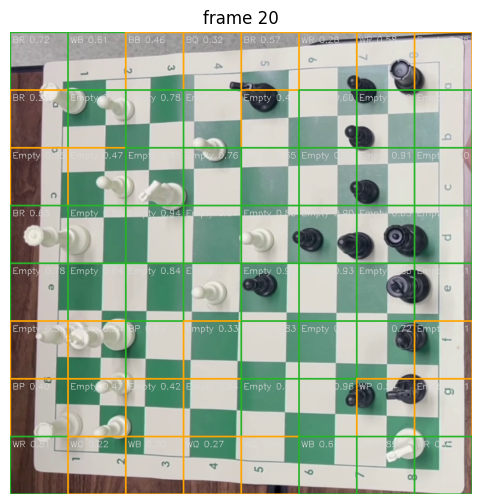

[frame 20] high-conf=0.62


KeyboardInterrupt: 

In [10]:
# cell3.2 — preview annotated video (old-style fast overlay)
import cv2, numpy as np, time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from Chess_Detection_Competition.inference import rotate_labels, orientation_score

def scan_H0(video_path, board_cfg, step=3, max_scan=180):
    cap = cv2.VideoCapture(str(video_path))
    H0 = None
    n = 0
    while cap.isOpened() and n < max_scan:
        ok = cap.grab(); n += 1
        if not ok or n % step != 0: continue
        ok, frame = cap.retrieve()
        if not ok: break
        warped, H = warp_board(frame, board_cfg)
        if H is not None:
            H0 = H
            break
    cap.release()
    return H0

def preview_old_style(video, predictor, cfg, tau=0.6, step=5, max_frames=150, save_path=None):
    H0 = scan_H0(video, cfg)
    cap = cv2.VideoCapture(str(video))
    writer = None
    if save_path:
        warp_size = int(cfg["board"]["warp_size"])
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        writer = cv2.VideoWriter(str(save_path), fourcc, 20.0, (warp_size, warp_size))

    f = 0
    while True:
        ok = cap.grab()
        if not ok: break
        f += 1
        if f % step != 0: continue
        ok, frame = cap.retrieve()
        if not ok: break

        if H0 is not None:
            warp_size = int(cfg["board"]["warp_size"])
            warped = cv2.warpPerspective(frame, H0, (warp_size, warp_size))
        else:
            warped, _ = warp_board(frame, cfg)

        labels, confs = predictor.predict_labels8x8(warped)
        ks = [(k, rotate_labels(labels, k)) for k in range(4)]
        kbest, labels = max(ks, key=lambda t: orientation_score(t[1]))
        for _ in range(kbest):
            confs = np.rot90(confs, k=-1)

        img = warped.copy()
        H, W = img.shape[:2]
        xs = np.linspace(0, W, 9).astype(int)
        ys = np.linspace(0, H, 9).astype(int)
        for x in xs: cv2.line(img, (x,0), (x,H-1), (255,255,255), 1)
        for y in ys: cv2.line(img, (0,y), (W-1,y), (255,255,255), 1)
        for r in range(8):
            for c in range(8):
                conf = float(confs[r, c])
                lbl = labels[r][c]
                color = (40,180,40) if conf >= tau else (0,165,255)
                x0, x1 = xs[c], xs[c+1]
                y0, y1 = ys[r], ys[r+1]
                cv2.rectangle(img, (x0,y0), (x1,y1), color, 2)
                cv2.putText(img, f"{lbl} {conf:.2f}", (x0+4, y0+18),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (220,220,220), 1)
        if writer: writer.write(img)

        clear_output(wait=True)
        plt.figure(figsize=(6,6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off"); plt.title(f"frame {f}")
        plt.show()
        print(f"[frame {f}] high-conf={(confs>=tau).mean():.2f}")

        if (f//step) >= max_frames:
            break

    cap.release()
    if writer: writer.release()
    print("done.")

# === Run it ===
if video_files:
    v = video_files[0]  # or pick manually
    print("Use:", v.name)
    out_mp4 = OUT_DIR / f"{v.stem}_annot_fast.mp4"
    preview_old_style(v, predictor, CFG_FOR_BOARD, tau=0.60, step=5, max_frames=150, save_path=None)


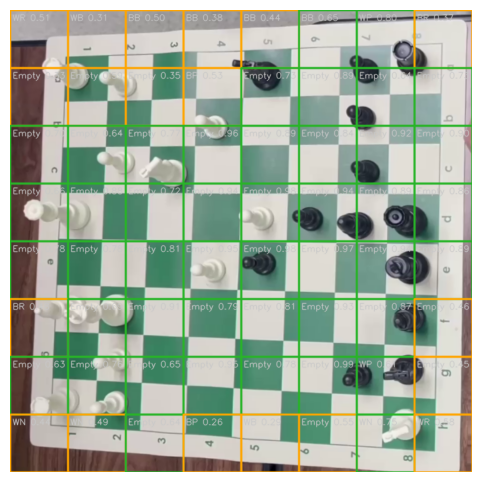

In [7]:
# cell4 — single-frame preview (grid + labels + conf)
import cv2
from matplotlib import pyplot as plt
import numpy as np

# import orientation helpers from inference.py
from Chess_Detection_Competition.inference import rotate_labels, orientation_score

def annotate_cells(warped_bgr, labels, confs, tau=0.60):
    img = warped_bgr.copy()
    H, W = img.shape[:2]
    xs = np.linspace(0, W, 9).astype(int)
    ys = np.linspace(0, H, 9).astype(int)
    for x in xs: cv2.line(img, (x,0), (x,H-1), (255,255,255), 1, cv2.LINE_AA)
    for y in ys: cv2.line(img, (0,y), (W-1,y), (255,255,255), 1, cv2.LINE_AA)
    for r in range(8):
        for c in range(8):
            x0, x1 = int(xs[c]), int(xs[c+1])
            y0, y1 = int(ys[r]), int(ys[r+1])
            conf = float(confs[r, c])
            lbl  = labels[r][c]
            color = (40,180,40) if conf >= tau else (0,165,255)
            cv2.rectangle(img, (x0,y0), (x1,y1), color, 2, cv2.LINE_AA)
            cv2.putText(img, f"{lbl} {conf:.2f}", (x0+4, y0+18),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (200,200,200), 1, cv2.LINE_AA)
    return img

if video_files:
    cap = cv2.VideoCapture(str(video_files[0]))
    ok, frame = cap.read(); cap.release()
    warped, _ = warp_board(frame, CFG_FOR_BOARD)  # <-- นิยามแล้วใน Cell 1
    labels, confs = predictor.predict_labels8x8(warped)

    # choose orientation
    ks = [(k, rotate_labels(labels, k)) for k in range(4)]
    kbest, labels = max(ks, key=lambda t: orientation_score(t[1]))
    for _ in range(kbest):
        confs = np.rot90(confs, k=-1)

    overlay = annotate_cells(warped, labels, confs, tau=TAU)
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.show()
